In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline*
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/DT-rse


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from ernesto.postprocessing.visualization import ernesto_plotter
from ernesto.postprocessing.metrics import compute_metrics, _mse

from sklearn.cluster import DBSCAN, KMeans, HDBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA

In [3]:
pathfile = "data/external/paper_dic24/Prova_salto_nuova/DT_parameters_1RC_5T_single_cell_C15_per_Davide.xlsx"

xls = pd.ExcelFile(pathfile)
df_params = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

In [4]:
cols_to_drop = ['filename', 'data', 'start interval', 'end interval', 'skip', 'num value extrap', 'Rsqd', 'RMSE fitting']

temps_to_add = {
    'T = 0': 0,
    'T = 10': 10,
    'T = 20': 20,
    'T = 30': 30,
    'T = 40': 40
}

var_labels = {
    'Soc': 'soc',
    'R_0': 'r0',
    'R_1': 'r1',
    'C_1': 'c1',
    'R_2': 'r2',
    'C_2': 'c2',
    'OCV': 'ocv'
}

In [5]:
for key, df in df_params.items():
    df.drop(columns=cols_to_drop, inplace=True)
    df.drop(columns=[col for col in df.columns if col.startswith('Unnamed')], inplace=True)
    df['temp'] = [temps_to_add[key] for _ in range(len(df))]
    df.rename(columns=var_labels, inplace=True)

In [6]:
df_params['T = 0']

,soc,r0,r1,c1,ocv,temp
0,100,0.005951,0.002942,10659.636448,4.174497,0
1,90,0.005921,0.007729,7198.722594,4.017757,0
2,80,0.005770,0.007483,8956.178017,3.913561,0
3,70,0.005826,0.007141,8409.383822,3.815149,0
4,60,0.005830,0.007193,7470.025430,3.719940,0
5,50,0.005917,0.007790,6617.542975,3.652467,0
6,40,0.005894,0.008995,5326.965646,3.607811,0
7,30,0.005820,0.011913,2796.826156,3.571659,0
8,20,0.005448,0.022881,310.895337,3.526204,0
9,10,0.006402,0.021622,187.006947,3.444296,0


In [7]:
df_complete = df_params['T = 0']

for key in list(df_params.keys())[1:]:
    df_complete = pd.concat([df_complete, df_params[key]], ignore_index=True)

In [8]:
df_complete

,soc,r0,r1,c1,ocv,temp
0,100,0.005951,0.002942,10659.636448,4.174497,0
1,90,0.005921,0.007729,7198.722594,4.017757,0
2,80,0.005770,0.007483,8956.178017,3.913561,0
3,70,0.005826,0.007141,8409.383822,3.815149,0
4,60,0.005830,0.007193,7470.025430,3.719940,0
5,50,0.005917,0.007790,6617.542975,3.652467,0
6,40,0.005894,0.008995,5326.965646,3.607811,0
7,30,0.005820,0.011913,2796.826156,3.571659,0
8,20,0.005448,0.022881,310.895337,3.526204,0
9,10,0.006402,0.021622,187.006947,3.444296,0


In [9]:
df_complete['soc'] /= 100

In [10]:
#df_complete.to_csv('../../data/config/params/lookup_module_2exp-salto_termico_nuovo.csv', index=False)

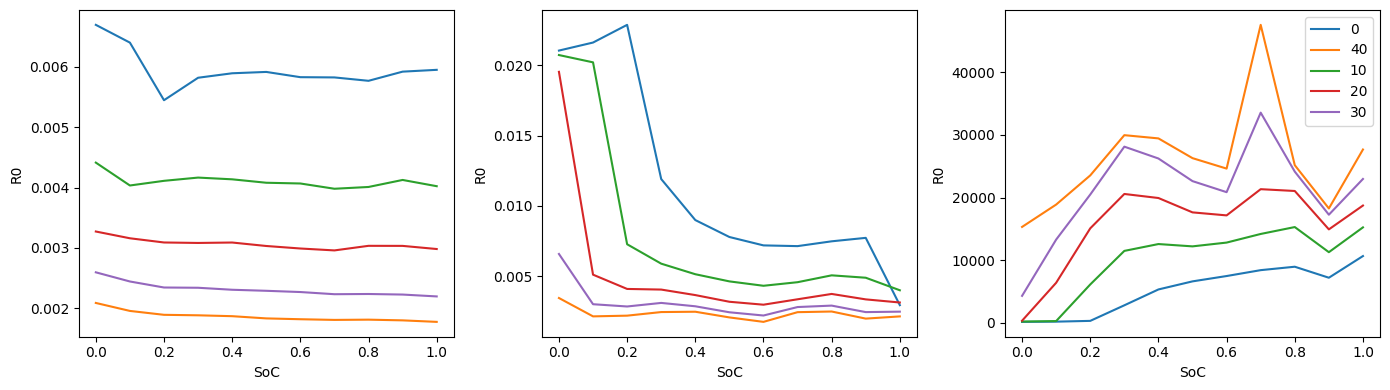

In [11]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))

for temp in set(df_complete['temp'].values):
    r0 = df_complete[df_complete['temp'] == temp]['r0']
    r1 = df_complete[df_complete['temp'] == temp]['r1']
    c1 = df_complete[df_complete['temp'] == temp]['c1']
    
    soc = df_complete[df_complete['temp'] == temp]['soc']
    
    ax[0].plot(soc, r0, label=temp)
    ax[0].set_xlabel("SoC")
    ax[0].set_ylabel("R0")

    ax[1].plot(soc, r1, label=temp)
    ax[1].set_xlabel("SoC")
    ax[1].set_ylabel("R0")
    
    ax[2].plot(soc, c1, label=temp)
    ax[2].set_xlabel("SoC")
    ax[2].set_ylabel("R0")

plt.tight_layout()
plt.legend()

In [12]:
df_dbscan = None
df_dbscan = df_complete.copy()

# Select features and normalize
features = df_dbscan[['r0', 'r1', 'c1']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=0.3, min_samples=5)  # adjust eps and min_samples as needed
dbscan_predictions = dbscan.fit_predict(X_scaled)

# Add to dataframe
df_dbscan['dbscan_label'] = dbscan_predictions

# Filter out noise points
filtered_df = df_dbscan[df_dbscan['dbscan_label'] != -1]

In [13]:
df_dbscan

,soc,r0,r1,c1,ocv,temp,dbscan_label
0,1.0,0.005951,0.002942,10659.636448,4.174497,0,-1
1,0.9,0.005921,0.007729,7198.722594,4.017757,0,0
2,0.8,0.005770,0.007483,8956.178017,3.913561,0,0
3,0.7,0.005826,0.007141,8409.383822,3.815149,0,0
4,0.6,0.005830,0.007193,7470.025430,3.719940,0,0
5,0.5,0.005917,0.007790,6617.542975,3.652467,0,0
6,0.4,0.005894,0.008995,5326.965646,3.607811,0,0
7,0.3,0.005820,0.011913,2796.826156,3.571659,0,-1
8,0.2,0.005448,0.022881,310.895337,3.526204,0,-1
9,0.1,0.006402,0.021622,187.006947,3.444296,0,-1


In [14]:
clusters = {}

for label in set(df_dbscan['dbscan_label']):
    clusters[label] = df_dbscan[df_dbscan['dbscan_label'] == label][['r0', 'r1', 'c1']]

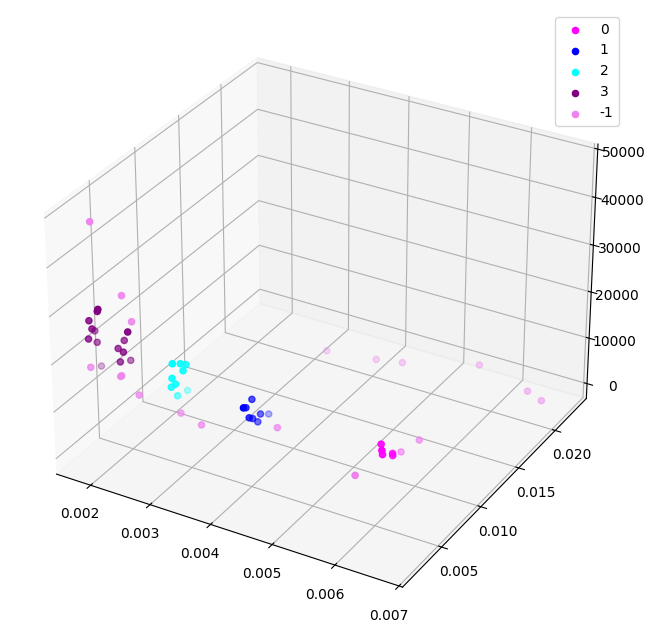

In [15]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['magenta', 'blue', 'cyan', 'purple', 'violet']

for i, label in enumerate(clusters.keys()):
    data = df_dbscan[df_dbscan['dbscan_label'] == label]
    ax.scatter(data['r0'], data['r1'], data['c1'], color=colors[i], label=label)
ax.legend()

In [16]:
[len(df_dbscan[df_dbscan['dbscan_label'] == label]) for label in clusters.keys()]

[6, 8, 9, 14, 18]

In [17]:
clusters[0].to_numpy(dtype=[('r0', 'f4'), ('r1', 'f4'), ('c1', 'f4')])

array([[(5.9213620e-03, 5.9213620e-03, 5.9213620e-03),
        (7.7289306e-03, 7.7289306e-03, 7.7289306e-03),
        (7.1987227e+03, 7.1987227e+03, 7.1987227e+03)],
       [(5.7695578e-03, 5.7695578e-03, 5.7695578e-03),
        (7.4831014e-03, 7.4831014e-03, 7.4831014e-03),
        (8.9561777e+03, 8.9561777e+03, 8.9561777e+03)],
       [(5.8256700e-03, 5.8256700e-03, 5.8256700e-03),
        (7.1409182e-03, 7.1409182e-03, 7.1409182e-03),
        (8.4093838e+03, 8.4093838e+03, 8.4093838e+03)],
       [(5.8297534e-03, 5.8297534e-03, 5.8297534e-03),
        (7.1929670e-03, 7.1929670e-03, 7.1929670e-03),
        (7.4700254e+03, 7.4700254e+03, 7.4700254e+03)],
       [(5.9166867e-03, 5.9166867e-03, 5.9166867e-03),
        (7.7899816e-03, 7.7899816e-03, 7.7899816e-03),
        (6.6175430e+03, 6.6175430e+03, 6.6175430e+03)],
       [(5.8943518e-03, 5.8943518e-03, 5.8943518e-03),
        (8.9949146e-03, 8.9949146e-03, 8.9949146e-03),
        (5.3269658e+03, 5.3269658e+03, 5.3269658e+03)]],
   

In [55]:
from scipy.stats import shapiro
from sklearn.decomposition import PCA

for label in df_dbscan['dbscan_label'].unique():
    subset = df_dbscan[df_dbscan['dbscan_label'] == label].drop(columns=['dbscan_label', 'temp', 'soc'])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(subset)

    print(f"Cluster {label}")
    for i in range(2):
        stat, p = shapiro(reduced[:, i])
        print(f"  PC{i+1}: p-value={p}")

Cluster -1
  PC1: p-value=0.0030386599544871954
  PC2: p-value=0.7628467617066238
Cluster 0
  PC1: p-value=0.9411424982681614
  PC2: p-value=0.009429233743287876
Cluster 1
  PC1: p-value=0.26766658130825416
  PC2: p-value=0.02001903777785734
Cluster 2
  PC1: p-value=0.315717442804329
  PC2: p-value=0.4704126642220204
Cluster 3
  PC1: p-value=0.9705543844131621
  PC2: p-value=0.03623341816896964


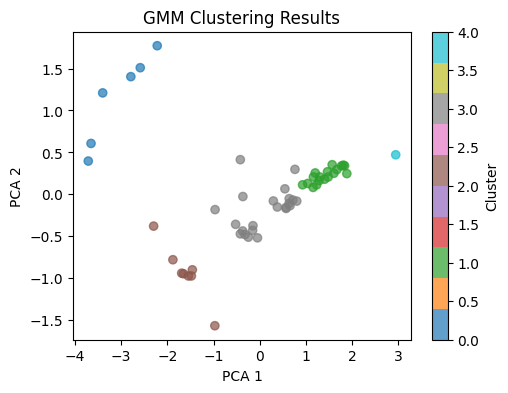

In [63]:
from sklearn.mixture import GaussianMixture

df_gmm = None
df_gmm = df_complete.copy()

# Example: Assume `df` is your DataFrame with features
X = df_gmm[['r0', 'r1', 'c1']]

# Optional: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit GMM
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)

# Add labels back to the DataFrame
df_gmm['gmm_cluster'] = labels

# Plot with PCA (or use TSNE/UMAP if higher-dim)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title("GMM Clustering Results")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')

plt.show()

In [62]:
df_gmm

,soc,r0,r1,c1,ocv,temp,gmm_cluster
0,1.0,0.005951,0.002942,10659.636448,4.174497,0,2
1,0.9,0.005921,0.007729,7198.722594,4.017757,0,2
2,0.8,0.005770,0.007483,8956.178017,3.913561,0,2
3,0.7,0.005826,0.007141,8409.383822,3.815149,0,2
4,0.6,0.005830,0.007193,7470.025430,3.719940,0,2
5,0.5,0.005917,0.007790,6617.542975,3.652467,0,2
6,0.4,0.005894,0.008995,5326.965646,3.607811,0,2
7,0.3,0.005820,0.011913,2796.826156,3.571659,0,2
8,0.2,0.005448,0.022881,310.895337,3.526204,0,5
9,0.1,0.006402,0.021622,187.006947,3.444296,0,5


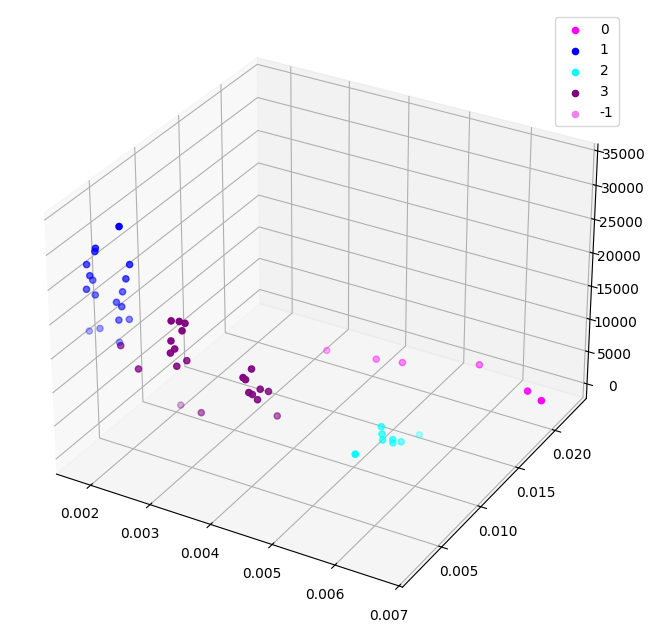

In [64]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['magenta', 'blue', 'cyan', 'purple', 'violet']

for i, label in enumerate(clusters.keys()):
    data = df_gmm[df_gmm['gmm_cluster'] == label]
    ax.scatter(data['r0'], data['r1'], data['c1'], color=colors[i], label=label)
ax.legend()

In [37]:
pathfile = "data/external/DT_CU1_parameters_1_exp_all_cells-OL.xlsx"

xls = pd.ExcelFile(pathfile)
df_params = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

In [38]:
for key in df_params.keys():
    df_params[key].columns = df_params[key].iloc[0]
    df_params[key] = df_params[key][1:].reset_index(drop=True)

In [39]:
df_params['T = 40']

,filename,data,start interval,end interval,Soc,skip,num value extrap,R_0,R_1,C_1,OCV,Rsqd,RMSE fitting,Cella
0,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,NaN,Not present - param from extrapolation,Not present - param from extrapolation,100,0,8,0.002144,0.002572,39169.448193,4.0715,Not present - param from extrapolation,Not present - param from extrapolation,1
1,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-20 00:00:00,17:56:19.030000,19:56:18.783000,90,0,8,0.002303,0.001966,41905.944786,4.049,0.554258,0.001061,1
2,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-20 00:00:00,20:08:19.882000,22:08:19.366000,80,0,8,0.002125,0.002752,32252.520503,3.953,0.575481,0.001455,1
3,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-20 00:00:00,22:20:21.687000,00:20:21.514000,70,0,8,0.002239,0.003731,38282.098658,3.868,0.742739,0.001726,1
4,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-21 00:00:00,00:32:23.231000,02:32:22.628000,60,0,8,0.002233,0.002545,59970.64657,3.772,0.607054,0.001547,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-23 00:00:00,06:56:57.995000,08:56:57.654000,40,0,8,0.002476,0.002951,39787.364708,3.67,0.830932,0.000983,14
458,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-23 00:00:00,09:08:59.976000,11:08:59.684000,30,0,8,0.002544,0.003094,51741.018882,3.636,0.822265,0.001229,14
459,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-23 00:00:00,11:21:00.904000,13:21:00.402000,20,0,8,0.00249,0.002714,43642.748498,3.586,0.5628,0.001638,14
460,20240520_20240523_concat_DT_EIG_CU1_40C_new_fo...,2024-05-23 00:00:00,13:33:02.848000,15:33:02.514000,10,0,8,0.00266,0.002539,44823.906695,3.527,0.517026,0.001669,14


In [40]:
cols_to_drop = ['filename', 'data', 'start interval', 'end interval', 'skip', 'num value extrap', 'Rsqd', 'RMSE fitting']

temps_to_add = {
    'T = 0': 0,
    'T = 10': 10,
    'T = 20': 20,
    'T = 25': 25,
    'T = 30': 30,
    'T = 40': 40
}

var_labels = {
    'Soc': 'soc',
    'R_0': 'r0',
    'R_1': 'r1',
    'C_1': 'c1',
    'OCV': 'ocv'
}

In [41]:
for key, df in df_params.items():
    df.drop(columns=cols_to_drop, inplace=True)
    df.drop(columns=[col for col in df.columns if col.startswith('Unnamed')], inplace=True)
    df['temp'] = [temps_to_add[key] for _ in range(len(df))]
    df.rename(columns=var_labels, inplace=True)

In [42]:
df_params['T = 10']

,soc,r0,r1,c1,ocv,Cella,temp
0,100,0.004603,0.004299,25255.893647,4.060821,1,10
1,90,0.004911,0.004313,20981.802704,4.043,1,10
2,80,0.005204,0.005542,20978.297191,3.945,1,10
3,70,0.005055,0.006895,37199.802234,3.855,1,10
4,60,0.005276,0.005197,19507.008836,3.754,1,10
...,...,...,...,...,...,...,...
457,40,0.005552,0.006053,26663.239802,3.659,14,10
458,30,0.005801,0.007481,29478.163133,3.631,14,10
459,20,0.006172,0.008359,18377.101679,3.582,14,10
460,10,0.010082,0.0119,6289.859689,3.519,14,10


In [43]:
df_complete = df_params['T = 10']

for key in list(df_params.keys())[1:]:
    df_complete = pd.concat([df_complete, df_params[key]], ignore_index=True)

In [44]:
df_complete = df_complete[~df_complete["Cella"].astype(int).isin([1, 2, 13, 14])]

In [45]:
df_complete = df_complete.drop(columns=['Cella', 'ocv'])

### DBSCAN on all the cells

In [46]:
df_dbscan = None
df_dbscan = df_complete.copy()

# Select features and normalize
features = df_dbscan[['r0', 'r1', 'c1']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=0.5, min_samples=5)  # adjust eps and min_samples as needed
dbscan_predictions = dbscan.fit_predict(X_scaled)

# Add to dataframe
df_dbscan['dbscan_label'] = dbscan_predictions

# Filter out noise points
filtered_df = df_dbscan[df_dbscan['dbscan_label'] != -1]

In [47]:
df_dbscan

,soc,r0,r1,c1,temp,dbscan_label
66,100,0.004189,0.004128,25799.900637,10,0
67,90,0.0044,0.004107,21499.727035,10,0
68,80,0.004796,0.005343,21614.689018,10,0
69,70,0.004642,0.006803,37270.299861,10,0
70,60,0.004966,0.005033,20629.946968,10,0
...,...,...,...,...,...,...
1315,40,0.002063,0.002932,39069.428723,40,6
1316,30,0.002137,0.003112,50836.82788,40,6
1317,20,0.002075,0.002719,43360.562434,40,6
1318,10,0.002251,0.002577,41144.531052,40,6


In [48]:
clusters = {}

for label in set(df_dbscan['dbscan_label']):
    clusters[label] = df_dbscan[df_dbscan['dbscan_label'] == label][['r0', 'r1', 'c1']]

In [49]:
clusters

{0: 0          r0        r1            c1
 66   0.004189  0.004128  25799.900637
 67     0.0044  0.004107  21499.727035
 68   0.004796  0.005343  21614.689018
 69   0.004642  0.006803  37270.299861
 70   0.004966  0.005033  20629.946968
 ..        ...       ...           ...
 851  0.004759  0.005058  22426.334938
 852  0.005247  0.005092  24436.436449
 853  0.005148   0.00613  25454.616712
 854  0.005394   0.00758  28187.329464
 855  0.005858  0.008398  17944.844859
 
 [540 rows x 3 columns],
 1: 0          r0        r1           c1
 75   0.006464  0.013916  2982.049373
 108  0.006464  0.013962   2956.84555
 141  0.006258  0.013638   3095.91421
 174  0.006258  0.013642  3090.460269
 207  0.006361  0.012861  3643.741548
 240  0.006361  0.012864  3638.674706
 273  0.006361  0.013959  2888.885079
 306  0.006464  0.013997  2866.629131
 339  0.006361  0.014521  2646.672162
 372  0.006464  0.014553  2643.457871
 537  0.006464  0.013916  2982.049373
 570  0.006464  0.013962   2956.84555
 603 

In [55]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['magenta', 'blue', 'cyan', 'purple', 'violet', 'red', 'orange', 'green', 'pink', 'brown', 'grey', 'yellow']

for i, label in enumerate(clusters.keys()):
    data = df_dbscan[df_dbscan['dbscan_label'] == label]
    ax.scatter(data['r0'], data['r1'], data['c1'], label=label)
    ax.legend()

Error in callback <function _draw_all_if_interactive at 0x10e9f0360> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'float' object has no attribute 'view'

AttributeError: 'float' object has no attribute 'view'

<Figure size 1200x800 with 1 Axes>

In [56]:
data

,soc,r0,r1,c1,temp,dbscan_label
230,0,0.011793,0.031978,639.170999,10,-1
263,0,0.011793,0.031982,639.701215,10,-1
692,0,0.011793,0.031978,639.170999,10,-1
725,0,0.011793,0.031982,639.701215,10,-1


In [51]:
[len(df_dbscan[df_dbscan['dbscan_label'] == label]) for label in clusters.keys()]

[540, 20, 32, 40, 16, 8, 330, 4]

In [52]:
from scipy.stats import shapiro
from sklearn.decomposition import PCA

for label in df_dbscan['dbscan_label'].unique():
    subset = df_dbscan[df_dbscan['dbscan_label'] == label].drop(columns=['dbscan_label', 'temp', 'soc'])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(subset)

    print(f"Cluster {label}")
    for i in range(2):
        stat, p = shapiro(reduced[:, i])
        print(f"  PC{i+1}: p-value={p:.4f}")

Cluster 0
  PC1: p-value=0.0000
  PC2: p-value=0.0000
Cluster 1
  PC1: p-value=0.0036
  PC2: p-value=0.0085
Cluster 2
  PC1: p-value=0.1022
  PC2: p-value=0.0011
Cluster 3
  PC1: p-value=0.0091
  PC2: p-value=0.0115
Cluster 4
  PC1: p-value=0.0003
  PC2: p-value=0.0103
Cluster 5
  PC1: p-value=0.0076
  PC2: p-value=0.0513
Cluster -1
  PC1: p-value=0.0239
  PC2: p-value=0.6830
Cluster 6
  PC1: p-value=0.0000
  PC2: p-value=0.0000
